# Analyse des données médiatiques d'Apple

In [2]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import time
import zipfile
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from scipy import stats
warnings.filterwarnings('ignore')

On veut calculer le score médiatique d'Apple à partir des données GDELT 2.0 dans lesquelles on peut trouver le nombre de mentions, le sentiment moyen etc.

In [ ]:
class GDELTMediaScore:
    """Analyse de la couverture médiatique d'Apple via GDELT 2.0"""
    
    def __init__(self):
        self.base_url = "http://data.gdeltproject.org/gdeltv2/"
        self.results = []
        
    def generate_file_urls(self, start_date, end_date):
        """Génère les URLs des fichiers GDELT pour la période"""
        urls = []
        # GDELT 2.0 a commencé le 19 février 2015
        actual_start = max(start_date, datetime(2015, 2, 19))
        current = actual_start
        
        while current <= end_date:
            # Fichier de midi (plus de chances d'avoir des données)
            timestamp = current.strftime("%Y%m%d120000")
            url = f"{self.base_url}{timestamp}.gkg.csv.zip"
            urls.append((current, url))
            current += timedelta(days=1)
            
        return urls
    
    def download_and_parse(self, date, url, max_retries=2):
        """Télécharge et analyse un fichier GDELT de manière optimisée"""
        for attempt in range(max_retries):
            try:
                print(f"{date.strftime('%Y-%m-%d')}...", end=" ", flush=True)
                
                response = requests.get(url, timeout=20, stream=True)
                if response.status_code == 404:
                    print("✗", end=" ")
                    return None
                    
                response.raise_for_status()
                
                # Colonnes principales du GKG
                usecols = [1, 3, 13, 14, 15]  # DATE, SourceCommonName, Organizations, V2Organizations, V2Tone
                column_names = ['DATE', 'SourceCommonName', 'Organizations', 'V2Organizations', 'V2Tone']
                
                # Lecture optimisée avec chunks
                with zipfile.ZipFile(BytesIO(response.content)) as zf:
                    csv_filename = zf.namelist()[0]
                    
                    mentions_count = 0
                    tones = []
                    sources = set()
                    
                    with zf.open(csv_filename) as f:
                        # Lecture par chunks pour éviter le buffer overflow
                        for chunk in pd.read_csv(
                            f,
                            sep='\t',
                            header=None,
                            usecols=usecols,
                            names=column_names,
                            chunksize=5000,
                            low_memory=False,
                            on_bad_lines='skip',
                            encoding='utf-8',
                            encoding_errors='ignore'
                        ):
                            # Filtrer pour Apple
                            apple_mask = (
                                chunk['Organizations'].fillna('').str.contains('Apple', case=False, na=False) |
                                chunk['V2Organizations'].fillna('').str.contains('Apple', case=False, na=False)
                            )
                            
                            apple_chunk = chunk[apple_mask]
                            
                            if len(apple_chunk) > 0:
                                mentions_count += len(apple_chunk)
                                
                                # Extraire les tones
                                for tone_str in apple_chunk['V2Tone'].dropna():
                                    try:
                                        tone_val = float(str(tone_str).split(',')[0])
                                        if -10 <= tone_val <= 10:  # Validation
                                            tones.append(tone_val)
                                    except:
                                        continue
                                
                                # Compter les sources
                                sources.update(apple_chunk['SourceCommonName'].dropna().unique())
                    
                    if mentions_count > 0 and tones:
                        result = {
                            'date': date,
                            'mentions': mentions_count,
                            'avg_tone': np.mean(tones),
                            'median_tone': np.median(tones),
                            'positive_ratio': len([t for t in tones if t > 0]) / len(tones),
                            'sources': len(sources)
                        }
                        print(f"✓ {mentions_count}", end=" ")
                        return result
                
                print("∅", end=" ")
                return None
                
            except zipfile.BadZipFile:
                print("✗(zip)", end=" ")
                return None
            except Exception as e:
                if "buffer overflow" in str(e).lower() or "tokenizing" in str(e).lower():
                    print("✗(size)", end=" ")
                    return None
                if attempt < max_retries - 1:
                    time.sleep(1)
                else:
                    print(f"✗({type(e).__name__})", end=" ")
        
        return None
    
    def collect_data(self, start_date, end_date, sample_rate=7):
        """
        Collecte les données GDELT
        sample_rate: prendre 1 jour tous les N jours
        """
        print(f"\n{'='*70}")
        print(f"COLLECTE DONNÉES GDELT 2.0 - APPLE")
        print(f"{'='*70}")
        print(f"Période: {start_date.strftime('%Y-%m-%d')} à {end_date.strftime('%Y-%m-%d')}")
        print(f"Échantillonnage: 1 jour / {sample_rate}")
        print(f"Note: GDELT 2.0 commence le 19 février 2015")
        
        urls = self.generate_file_urls(start_date, end_date)
        sampled_urls = urls[::sample_rate]
        
        print(f"Fichiers à analyser: {len(sampled_urls)}")
        print(f"\nLégende: ✓=données, ✗=absent, ∅=aucune mention\n")
        
        count = 0
        for date, url in sampled_urls:
            result = self.download_and_parse(date, url)
            if result:
                self.results.append(result)
            
            count += 1
            if count % 10 == 0:
                print(f" [{count}/{len(sampled_urls)}]")
            
            time.sleep(0.5)  # Pause courte
        
        print(f"\n\n{'='*70}")
        print(f"✓ Collecte terminée: {len(self.results)} jours avec mentions Apple")
        print(f"{'='*70}\n")
        
    def calculate_media_score(self):
        """Calcule le score médiatique composite"""
        if not self.results:
            print("❌ Aucune donnée disponible pour calculer le score")
            return None
            
        df = pd.DataFrame(self.results)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        
        # Normalisation des métriques (0-1)
        df['mentions_norm'] = (df['mentions'] - df['mentions'].min()) / (df['mentions'].max() - df['mentions'].min() + 1e-6)
        df['tone_norm'] = (df['avg_tone'] + 10) / 20  # -10 à +10 → 0 à 1
        df['sources_norm'] = (df['sources'] - df['sources'].min()) / (df['sources'].max() - df['sources'].min() + 1e-6)
        
        # Score médiatique composite (0-100)
        df['media_score'] = (
            df['mentions_norm'] * 0.35 +      # Volume de couverture
            df['tone_norm'] * 0.25 +          # Sentiment
            df['positive_ratio'] * 0.25 +     # Positivité
            df['sources_norm'] * 0.15         # Diversité sources
        ) * 100
        
        # Moyennes mobiles pour lisser les tendances
        df['score_ma7'] = df['media_score'].rolling(window=7, min_periods=1).mean()
        df['score_ma30'] = df['media_score'].rolling(window=30, min_periods=1).mean()
        
        return df
    
    def visualize(self, df):
        """Visualise les résultats"""
        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)
        
        # 1. Score médiatique principal
        ax1 = fig.add_subplot(gs[0, :])
        ax1.plot(df['date'], df['media_score'], alpha=0.3, color='lightblue', linewidth=1)
        ax1.plot(df['date'], df['score_ma7'], color='#007AFF', linewidth=2, label='Moyenne 7 jours')
        ax1.plot(df['date'], df['score_ma30'], color='#FF9500', linewidth=2, label='Moyenne 30 jours')
        ax1.fill_between(df['date'], df['score_ma7'], alpha=0.2, color='#007AFF')
        ax1.set_title('📊 Score Médiatique Apple (0-100)', fontsize=16, fontweight='bold', pad=20)
        ax1.set_ylabel('Score', fontsize=12)
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 100)
        
        # 2. Mentions
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.bar(df['date'], df['mentions'], width=5, color='#34C759', alpha=0.6)
        ax2.set_title('📰 Volume de Mentions', fontsize=13, fontweight='bold')
        ax2.set_ylabel('Nombre', fontsize=11)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # 3. Sentiment
        ax3 = fig.add_subplot(gs[1, 1])
        colors = ['#FF3B30' if x < 0 else '#34C759' for x in df['avg_tone']]
        ax3.bar(df['date'], df['avg_tone'], width=5, color=colors, alpha=0.6)
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax3.set_title('😊 Sentiment Moyen', fontsize=13, fontweight='bold')
        ax3.set_ylabel('Tone (-10 à +10)', fontsize=11)
        ax3.grid(True, alpha=0.3, axis='y')
        
        # 4. Ratio positif
        ax4 = fig.add_subplot(gs[2, 0])
        ax4.plot(df['date'], df['positive_ratio']*100, color='#5856D6', linewidth=2)
        ax4.fill_between(df['date'], df['positive_ratio']*100, alpha=0.3, color='#5856D6')
        ax4.set_title('✅ Ratio de Sentiment Positif', fontsize=13, fontweight='bold')
        ax4.set_ylabel('Pourcentage (%)', fontsize=11)
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim(0, 100)
        
        # 5. Sources
        ax5 = fig.add_subplot(gs[2, 1])
        ax5.plot(df['date'], df['sources'], color='#FF2D55', linewidth=2, marker='o', markersize=3)
        ax5.set_title('🌐 Diversité des Sources', fontsize=13, fontweight='bold')
        ax5.set_ylabel('Nb de sources', fontsize=11)
        ax5.grid(True, alpha=0.3)
        
        # 6. Distribution du score
        ax6 = fig.add_subplot(gs[3, :])
        ax6.hist(df['media_score'], bins=30, color='#007AFF', alpha=0.7, edgecolor='black')
        ax6.axvline(df['media_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {df["media_score"].mean():.1f}')
        ax6.axvline(df['media_score'].median(), color='orange', linestyle='--', linewidth=2, label=f'Médiane: {df["media_score"].median():.1f}')
        ax6.set_title('📈 Distribution du Score Médiatique', fontsize=13, fontweight='bold')
        ax6.set_xlabel('Score', fontsize=11)
        ax6.set_ylabel('Fréquence', fontsize=11)
        ax6.legend()
        ax6.grid(True, alpha=0.3, axis='y')
        
        plt.suptitle('ANALYSE MÉDIATIQUE APPLE - GDELT 2.0', fontsize=18, fontweight='bold', y=0.995)
        plt.show()


🍎 ANALYSE MÉDIATIQUE APPLE VIA GDELT 2.0


COLLECTE DONNÉES GDELT 2.0 - APPLE
Période: 2015-02-19 à 2025-11-30
Échantillonnage: 1 jour / 14
Note: GDELT 2.0 commence le 19 février 2015
Fichiers à analyser: 282

Légende: ✓=données, ✗=absent, ∅=aucune mention

2015-02-19... 

✓ 2 2015-03-05... ✓ 5 2015-03-19... ✓ 3 2015-04-02... ✓ 6 2015-04-16... ✓ 4 2015-04-30... ✓ 6 2015-05-14... ✓ 4 2015-05-28... ✓ 1 2015-06-11... ✓ 2 2015-06-25... ✓ 1  [10/282]
2015-07-09... ✓ 2 2015-07-23... ✓ 10 2015-08-06... ✓ 5 2015-08-20... ✓ 6 2015-09-03... ✓ 12 2015-09-17... ✓ 5 2015-10-01... ✓ 5 2015-10-15... ✓ 12 2015-10-29... ✓ 11 2015-11-12... ✓ 5  [20/282]
2015-11-26... ✓ 3 2015-12-10... ✓ 1 2015-12-24... ✓ 7 2016-01-07... ✓ 3 2016-01-21... ✓ 7 2016-02-04... ✓ 3 2016-02-18... ✓ 11 2016-03-03... ✓ 3 2016-03-17... ✓ 7 2016-03-31... ✓ 7  [30/282]
2016-04-14... ✓ 5 2016-04-28... ✓ 14 2016-05-12... ✓ 2 2016-05-26... ✓ 3 2016-06-09... ✓ 9 2016-06-23... ✓ 7 2016-07-07... ✓ 8 2016-07-21... ✓ 23 2016-08-04... ✓ 7 2016-08-18... ✓ 7  [40/282]
2016-09-01... ✓ 7 2016-09-15... ✓ 13 2016-09-29... ✓ 3 2016-10-13... ✓ 6 2016-10-27... ✓ 17 2016-11-10... ✓ 5 2016-11-24... ✓ 4 2016-12-08... ✓ 20 2016-12-22... ✓ 6 2017-01-05... ✓ 7  [50/282]
2017-01-19... ✓ 2 2017-02-02... ✓ 4 2017-02-16... ✓ 7 

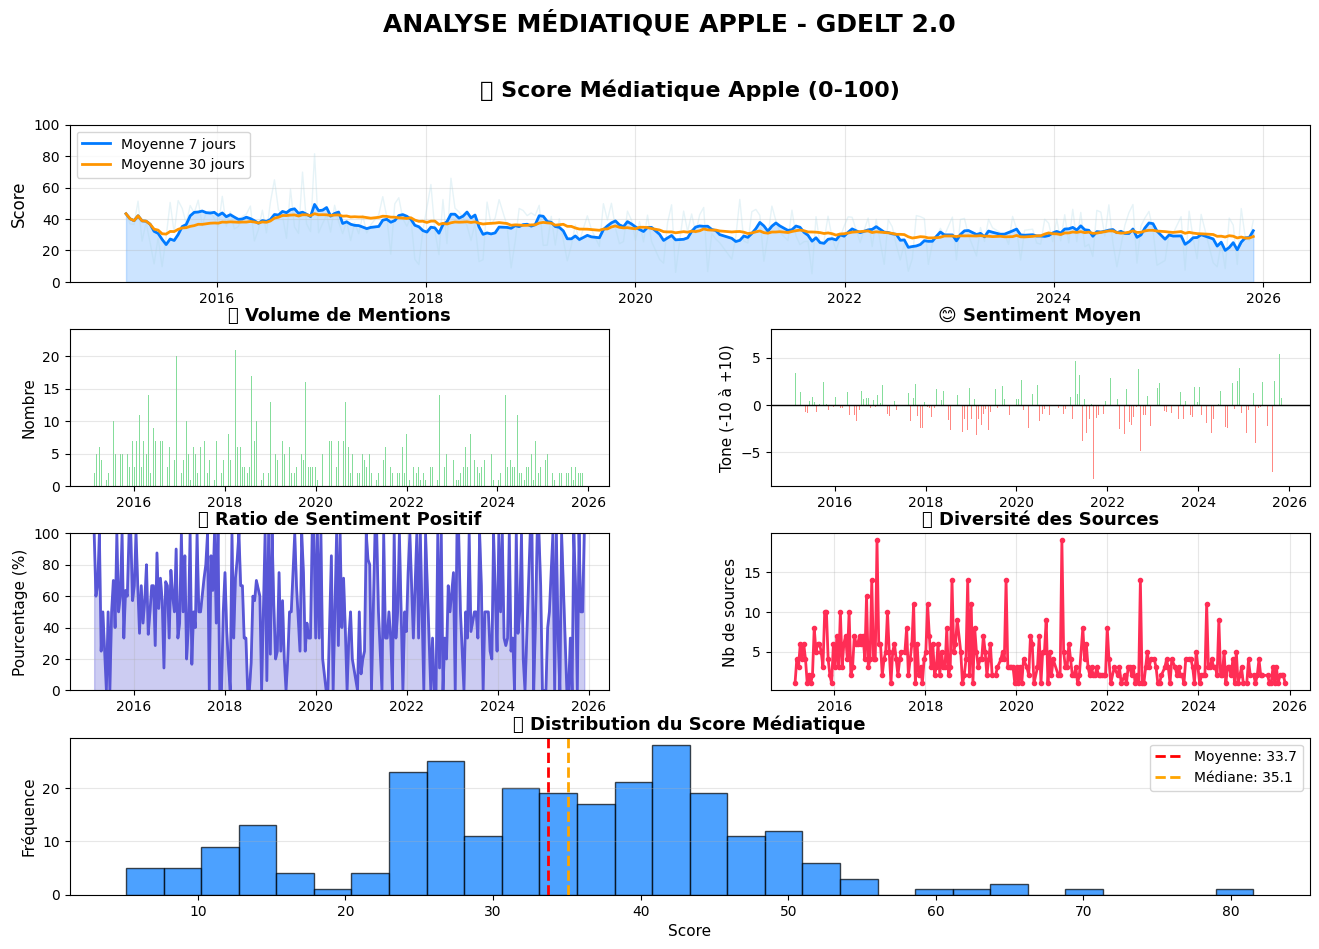

✅ Données exportées: apple_media_score.csv

✅ ANALYSE TERMINÉE AVEC SUCCÈS!



In [ ]:
if __name__ == "__main__":
    
    analyzer = GDELTMediaScore()
    
    # Période d'analyse
    start = datetime(2015, 2, 19)  # Début de GDELT 2.0
    end = datetime(2025, 11, 30)
    
    # Collecte (échantillonnage: 1 jour/semaine pour test rapide)
    # Changez à sample_rate=1 pour avoir TOUS les jours (long!)
    analyzer.collect_data(start, end, sample_rate=14)
    
    if len(analyzer.results) > 0:
        # Calcul du score
        df = analyzer.calculate_media_score()
        
        # Visualisation
        analyzer.visualize(df)
        
        # Export
        analyzer.export_results(df)

✅ Graphique sauvegardé: apple_media_analysis.png


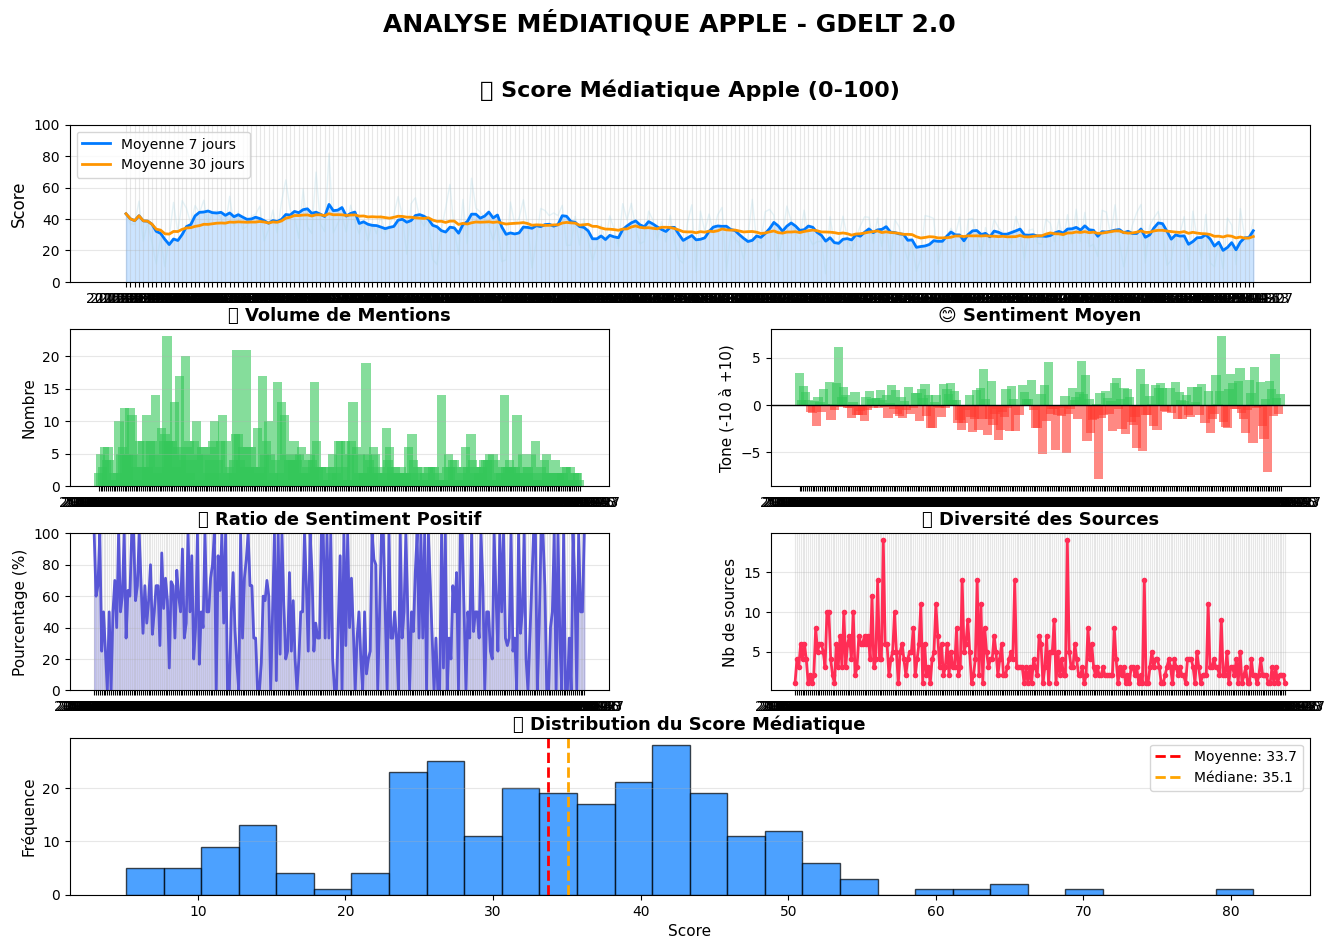

In [ ]:
analyzer = GDELTMediaScore()
df_finance = pd.read_csv("..\data\dataset_with_feature.csv")
df_media = pd.read_csv("..\data\apple_media_score.csv")

analyzer.visualize(df_media)

On veut ensuite observer les relations avec le rendement, la volatilité, le volume.

In [14]:
class MediaFinanceCorrelation:
    """Analyse des corrélations entre score médiatique et données financières"""
    
    def __init__(self, df_finance, df_media):
        """
        Parameters:
        -----------
        df_finance : DataFrame avec colonnes ['Date', 'Close', 'R1J', 'Volatilite 20J', 'volume_zscore']
        df_media : DataFrame du score médiatique avec colonnes ['date', 'media_score', ...]
        """
        self.df_finance = df_finance.copy()
        self.df_media = df_media.copy()
        self.df_merged = None
        
    def prepare_data(self):
        """Fusionne les datasets et prépare les données"""
        
        # Affichage des colonnes pour debug
        
        # Normalisation des colonnes de date pour df_finance
        if 'Date' in self.df_finance.columns:
            self.df_finance['date'] = pd.to_datetime(self.df_finance['Date'])
        elif 'date' in self.df_finance.columns:
            self.df_finance['date'] = pd.to_datetime(self.df_finance['date'])
        else:
            # Date dans l'index
            self.df_finance = self.df_finance.reset_index()
            if 'Date' in self.df_finance.columns:
                self.df_finance['date'] = pd.to_datetime(self.df_finance['Date'])
            elif 'index' in self.df_finance.columns:
                self.df_finance['date'] = pd.to_datetime(self.df_finance['index'])
            else:
                self.df_finance['date'] = pd.to_datetime(self.df_finance.iloc[:, 0])
        
        # Normalisation pour df_media
        if 'date' not in self.df_media.columns:
            if 'Date' in self.df_media.columns:
                self.df_media['date'] = pd.to_datetime(self.df_media['Date'])
            else:
                self.df_media = self.df_media.reset_index()
                if 'Date' in self.df_media.columns:
                    self.df_media['date'] = pd.to_datetime(self.df_media['Date'])
                else:
                    self.df_media['date'] = pd.to_datetime(self.df_media.iloc[:, 0])
        else:
            self.df_media['date'] = pd.to_datetime(self.df_media['date'])
        
        # Filtrer Apple uniquement dans les données financières
        # (Supposant que le ticker est dans l'index ou une colonne)
        if 'Ticker' in self.df_finance.columns:
            self.df_finance = self.df_finance[self.df_finance['Ticker'] == 'AAPL'].copy()

        
        # Merge sur les dates communes
        self.df_merged = pd.merge(
            self.df_finance[['date', 'Close', 'R1J', 'Volatilite 20J', 'volume_zscore']],
            self.df_media[['date', 'media_score', 'mentions', 'avg_tone', 'positive_ratio', 'sources']],
            on='date',
            how='inner'
        )

        
        # Variables dérivées utiles
        self.df_merged['abs_return'] = abs(self.df_merged['R1J'])
        self.df_merged['positive_return'] = (self.df_merged['R1J'] > 0).astype(int)
        
        # Lag variables (score médiatique avec décalage temporel)
        self.df_merged = self.df_merged.sort_values('date')
        self.df_merged['media_score_lag1'] = self.df_merged['media_score'].shift(1)
        self.df_merged['media_score_lag7'] = self.df_merged['media_score'].shift(7)
        
        # Lead variables (rendement futur)
        self.df_merged['R1J_lead1'] = self.df_merged['R1J'].shift(-1)
        self.df_merged['R1J_lead7'] = self.df_merged['R1J'].shift(-7)

        
        return self.df_merged
    
    def compute_correlations(self):
        """Calcule les corrélations entre variables"""
        
        # Variables d'intérêt
        correlation_vars = [
            'media_score', 'mentions', 'avg_tone', 'positive_ratio', 'sources',
            'R1J', 'abs_return', 'Volatilite 20J', 'volume_zscore', 'Close'
        ]
        
        # Corrélations Pearson
        corr_pearson = self.df_merged[correlation_vars].corr(method='pearson')
        
        # Corrélations Spearman (rang, plus robuste aux outliers)
        corr_spearman = self.df_merged[correlation_vars].corr(method='spearman')
        
        # Focus sur corrélations avec media_score

        media_corr = corr_pearson['media_score'].sort_values(ascending=False)


        media_corr_sp = corr_spearman['media_score'].sort_values(ascending=False)
        
        return corr_pearson, corr_spearman
    
    def test_significance(self):
        """Tests de significativité statistique"""

        vars_to_test = ['R1J', 'abs_return', 'Volatilite 20J', 'volume_zscore']
        
        results = []
        for var in vars_to_test:
            # Suppression des NaN
            data = self.df_merged[['media_score', var]].dropna()
            
            if len(data) > 0:
                # Corrélation de Pearson avec p-value
                corr, p_value = stats.pearsonr(data['media_score'], data[var])
                
                # Corrélation de Spearman avec p-value
                corr_sp, p_value_sp = stats.spearmanr(data['media_score'], data[var])
                
                results.append({
                    'variable': var,
                    'corr_pearson': corr,
                    'p_value_pearson': p_value,
                    'corr_spearman': corr_sp,
                    'p_value_spearman': p_value_sp,
                    'n_obs': len(data)
                })
        
        results_df = pd.DataFrame(results)

        for _, row in results_df.iterrows():
            sig_p = "***" if row['p_value_pearson'] < 0.001 else "**" if row['p_value_pearson'] < 0.01 else "*" if row['p_value_pearson'] < 0.05 else ""
            sig_s = "***" if row['p_value_spearman'] < 0.001 else "**" if row['p_value_spearman'] < 0.01 else "*" if row['p_value_spearman'] < 0.05 else ""
            
        
        return results_df
    
    def analyze_lagged_correlations(self):
        """Analyse des corrélations avec décalages temporels"""
        
        # Score médiatique prédit-il le rendement futur ?
        corr_lead1 = self.df_merged[['media_score', 'R1J_lead1']].corr().iloc[0, 1]
        corr_lead7 = self.df_merged[['media_score', 'R1J_lead7']].corr().iloc[0, 1]
        
        
        # Le rendement influence-t-il le score médiatique futur ?
        corr_lag1 = self.df_merged[['R1J', 'media_score_lag1']].corr().iloc[0, 1]
        corr_lag7 = self.df_merged[['R1J', 'media_score_lag7']].corr().iloc[0, 1]
        
    
    def quartile_analysis(self):
        """Analyse par quartiles du score médiatique"""
        
        # Diviser en quartiles
        self.df_merged['media_quartile'] = pd.qcut(
            self.df_merged['media_score'], 
            q=4, 
            labels=['Q1 (Faible)', 'Q2', 'Q3', 'Q4 (Élevé)']
        )
        
        # Statistiques par quartile
        quartile_stats = self.df_merged.groupby('media_quartile').agg({
            'R1J': ['mean', 'std', 'count'],
            'abs_return': 'mean',
            'Volatilite 20J': 'mean',
            'volume_zscore': 'mean',
            'media_score': 'mean'
        }).round(4)
        
        
        # Test ANOVA
        groups = [self.df_merged[self.df_merged['media_quartile'] == q]['R1J'].dropna() 
                  for q in ['Q1 (Faible)', 'Q2', 'Q3', 'Q4 (Élevé)']]
        f_stat, p_value = stats.f_oneway(*groups)
        
        
        return quartile_stats
    
    def visualize_correlations(self, corr_pearson, corr_spearman):
        """Visualisation des corrélations"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Heatmap corrélation Pearson
        vars_display = ['media_score', 'mentions', 'avg_tone', 'positive_ratio', 
                        'R1J', 'Volatilite 20J', 'volume_zscore']
        
        sns.heatmap(
            corr_pearson.loc[vars_display, vars_display],
            annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=axes[0, 0], vmin=-1, vmax=1
        )
        axes[0, 0].set_title('Matrice de Corrélation (Pearson)', fontsize=14, fontweight='bold', pad=15)
        
        # 2. Scatter: Score médiatique vs Rendement
        axes[0, 1].scatter(self.df_merged['media_score'], self.df_merged['R1J'], 
                          alpha=0.4, s=30, color='#007AFF')
        z = np.polyfit(self.df_merged['media_score'].dropna(), 
                       self.df_merged['R1J'].dropna(), 1)
        p = np.poly1d(z)
        axes[0, 1].plot(self.df_merged['media_score'], 
                        p(self.df_merged['media_score']), 
                        "r--", linewidth=2, label=f'Régression (r={corr_pearson.loc["media_score", "R1J"]:.3f})')
        axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        axes[0, 1].set_xlabel('Score Médiatique', fontsize=12)
        axes[0, 1].set_ylabel('Rendement 1J (%)', fontsize=12)
        axes[0, 1].set_title('Score Médiatique vs Rendement', fontsize=14, fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Score médiatique vs Volatilité
        axes[1, 0].scatter(self.df_merged['media_score'], self.df_merged['Volatilite 20J'], 
                          alpha=0.4, s=30, color='#FF9500')
        z = np.polyfit(self.df_merged['media_score'].dropna(), 
                       self.df_merged['Volatilite 20J'].dropna(), 1)
        p = np.poly1d(z)
        axes[1, 0].plot(self.df_merged['media_score'], 
                        p(self.df_merged['media_score']), 
                        "r--", linewidth=2, label=f'Régression (r={corr_pearson.loc["media_score", "Volatilite 20J"]:.3f})')
        axes[1, 0].set_xlabel('Score Médiatique', fontsize=12)
        axes[1, 0].set_ylabel('Volatilité 20J', fontsize=12)
        axes[1, 0].set_title('Score Médiatique vs Volatilité', fontsize=14, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Box plot rendement par quartile de score
        quartile_data = [self.df_merged[self.df_merged['media_quartile'] == q]['R1J'].dropna() 
                         for q in ['Q1 (Faible)', 'Q2', 'Q3', 'Q4 (Élevé)']]
        bp = axes[1, 1].boxplot(quartile_data, labels=['Q1\n(Faible)', 'Q2', 'Q3', 'Q4\n(Élevé)'],
                                patch_artist=True)
        for patch, color in zip(bp['boxes'], ['#FF3B30', '#FF9500', '#FFCC00', '#34C759']):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        axes[1, 1].set_xlabel('Quartile de Score Médiatique', fontsize=12)
        axes[1, 1].set_ylabel('Rendement 1J (%)', fontsize=12)
        axes[1, 1].set_title('Distribution des Rendements par Quartile', fontsize=14, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        plt.suptitle('ANALYSE DES CORRÉLATIONS - SCORE MÉDIATIQUE vs DONNÉES FINANCIÈRES', 
                     fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.savefig('correlations_media_finance.png', dpi=300, bbox_inches='tight')
        plt.show()

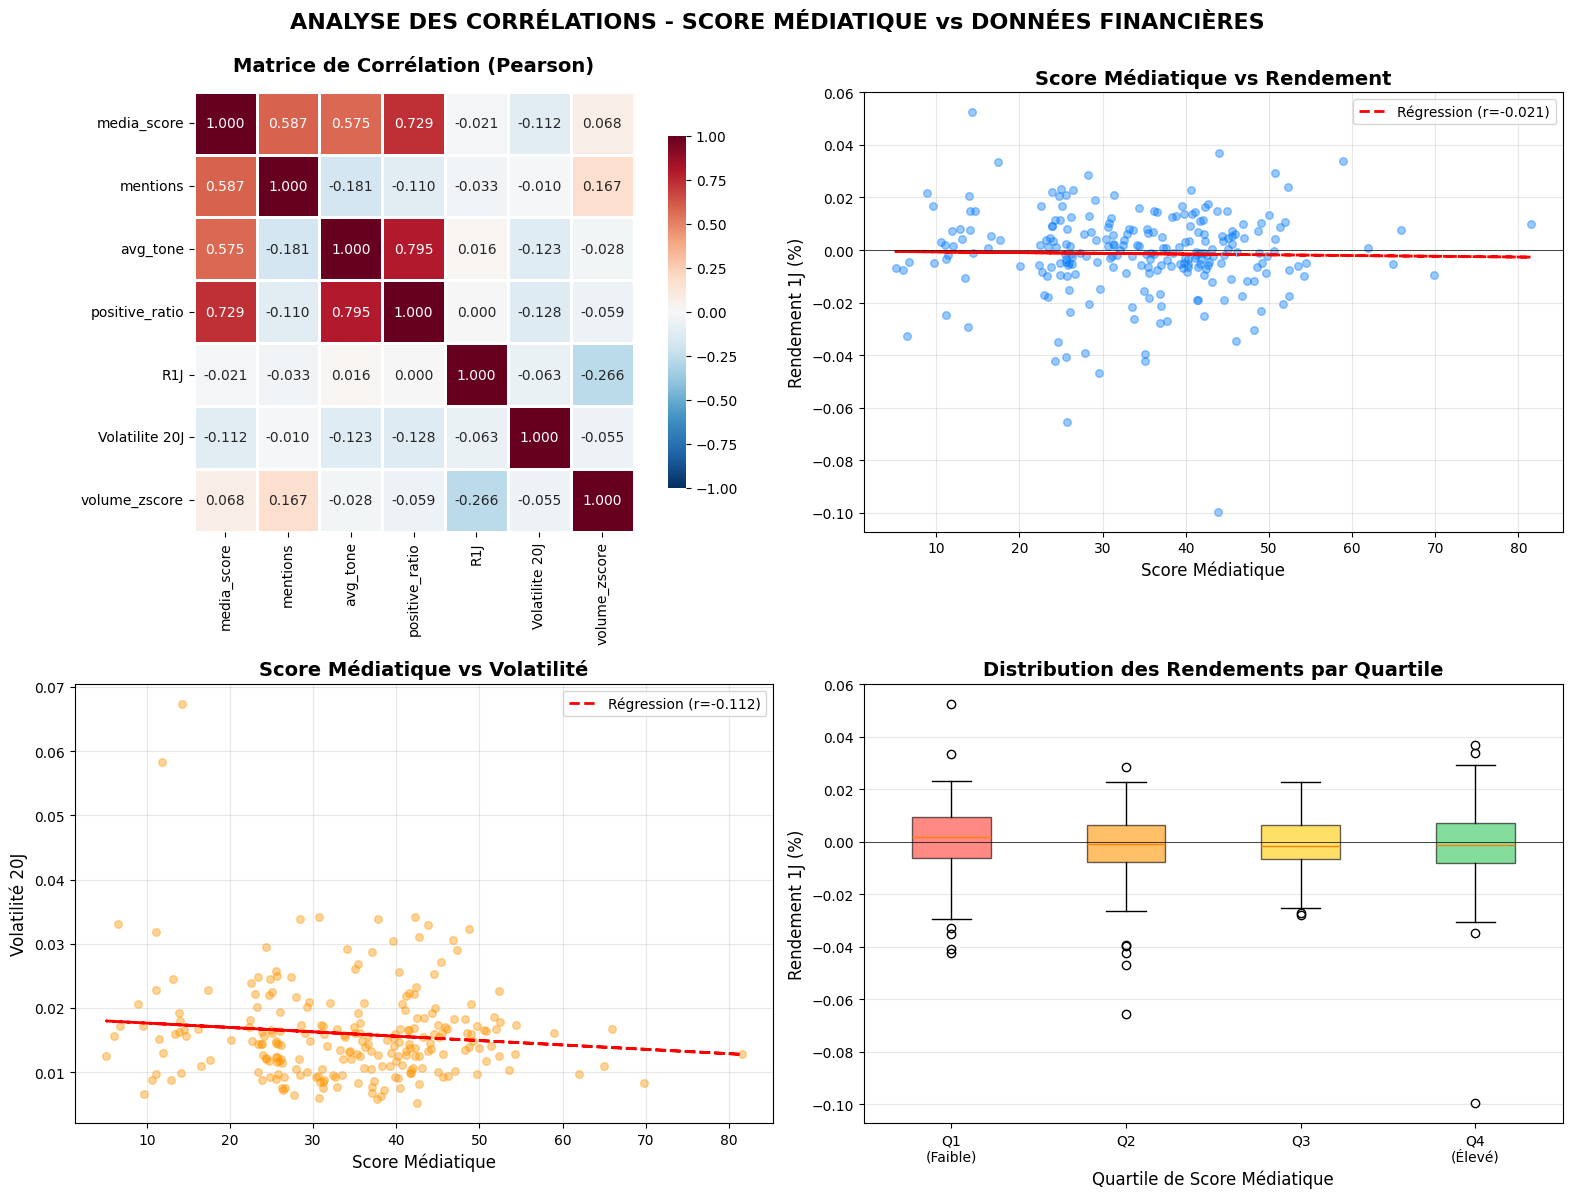

In [15]:
def analyze_media_finance_correlation(df_finance, df_media):
    """
    Fonction principale pour analyser les corrélations
    
    Parameters:
    -----------
    df_finance : DataFrame Yahoo Finance avec colonnes ['Date', 'Close', 'R1J', 'Volatilite 20J', 'volume_zscore']
    df_media : DataFrame score médiatique (résultat de GDELTMediaScore)
    """
    
    
    # Initialisation
    analyzer = MediaFinanceCorrelation(df_finance, df_media)
    
    # 1. Préparation des données
    df_merged = analyzer.prepare_data()
    
    # 2. Corrélations
    corr_pearson, corr_spearman = analyzer.compute_correlations()
    
    # 3. Tests de significativité
    significance_results = analyzer.test_significance()
    
    # 4. Analyse des décalages temporels
    analyzer.analyze_lagged_correlations()
    
    # 5. Analyse par quartiles
    quartile_stats = analyzer.quartile_analysis()
    
    # 6. Visualisation
    analyzer.visualize_correlations(corr_pearson, corr_spearman)
    
    # 7. Export

    
    return df_merged, corr_pearson, significance_results




df_merged, correlations, sig_tests = analyze_media_finance_correlation(df_finance, df_media)
